In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

# Setting the comet variables for the project
comet_api_key =  os.getenv("COMET_API_KEY")
comet_project_name = os.getenv("COMET_PROJECT_NAME")
comet_workspace_name = os.getenv("COMET_WORKSPACE_NAME")

In [2]:
# Integrating comet to track results
from comet_ml import Experiment
experiment = Experiment(
  api_key=comet_api_key,
  project_name=comet_project_name,
  workspace=comet_workspace_name,
  auto_metric_logging=True,
  auto_param_logging=True,
  auto_histogram_weight_logging=True,
  auto_histogram_gradient_logging=True,
  auto_histogram_activation_logging=True,
  auto_histogram_epoch_rate=True,
  log_code=True
)

# setting our experiment name in comet
experiment.set_name("custom_cnn_v1")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/nikhil527/image-emotion-classifier/298984a26b9845c0bc9281efd68aba14



In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [4]:
import sys 
import os

# Adding the parent directory to the sys.path to access helper_functions
parent_directory = os.path.dirname(os.getcwd())

# Adds our parent directory to the list of paths that python searches for modules
sys.path.append(parent_directory) 

from helper_functions import *

In [5]:
# Reading fer 2013 dataset
data = pd.read_csv(r'C:\Users\saini\OneDrive\Documents\masters\first semester\Machine learning\datasets\fer2013 csv dataset\fer2013\fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
np.asarray(data['pixels'].tolist()[0].split(' ')).reshape(48,48).astype('float32')

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

In [7]:
pixel_data_points = data['pixels'].tolist()
reshaped_pixel_array = []

for image_seq in pixel_data_points:
    y = [int(x) for x in image_seq.split(' ')]
    reshaped_pixel_array.append(np.asarray(y).reshape(48,48).astype('float32'))

reshaped_pixel_array = np.asarray(reshaped_pixel_array)
reshaped_pixel_array = np.expand_dims(reshaped_pixel_array, -1)
y = pd.get_dummies(data['emotion']).values

In [8]:
# centering the column mean around 0
reshaped_pixel_array -= np.mean(reshaped_pixel_array, axis=0)
# Reducing the spread of data around 0
reshaped_pixel_array /= np.std(reshaped_pixel_array, axis=0)


In [9]:
#splitting our data 
X_train, X_test, y_train, y_test = train_test_split(reshaped_pixel_array, y, test_size=0.1, random_state=44)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=40)

In [10]:
# Defining our model architecture
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [11]:
# we are adding early stopping to make sure that the model is not overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [12]:
# Training our model
with tf.device('/GPU:0'):
    model_results = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=70, verbose=1, validation_data=(np.array(X_valid), np.array(y_valid)), shuffle=True)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/70
909/909 [==============================] - 1373s 2s/step - loss: 1.9683 - accuracy: 0.2189 - val_loss: 1.8235 - val_accuracy: 0.2613
Epoch 2/70
909/909 [==============================] - 1207s 1s/step - loss: 1.8312 - accuracy: 0.2469 - val_loss: 1.7796 - val_accuracy: 0.2610
Epoch 3/70
909/909 [==============================] - 1131s 1s/step - loss: 1.7765 - accuracy: 0.2685 - val_loss: 1.6722 - val_accuracy: 0.3139
Epoch 4/70
909/909 [==============================] - 1172s 1s/step - loss: 1.6820 - accuracy: 0.3170 - val_loss: 1.5360 - val_accuracy: 0.3873
Epoch 5/70
909/909 [==============================] - 1083s 1s/step - loss: 1.5751 - accuracy: 0.3752 - val_loss: 1.4363 - val_accuracy: 0.4359
Epoch 6/70
909/909 [==============================] - 992s 1s/step - loss: 1.5107 - accuracy: 0.4045 - val_loss: 1.4025 - val_accuracy: 0.4508
Epoch 7/70
909/909 [==============================] - 1085s 1s/step - loss: 1.4666 - accuracy: 0.4226 - val_loss: 1.3422 - val_accuracy: 

COMET ERROR: Heartbeat processing error


 91/909 [==>...........................] - ETA: 13:52 - loss: 1.3092 - accuracy: 0.5007

COMET ERROR: Error sending stdout/stderr batch (online experiment)


113/909 [==>...........................] - ETA: 13:29 - loss: 1.3144 - accuracy: 0.4975

COMET ERROR: Error sending parameters batch (online experiment)


909/909 [==============================] - 1002s 1s/step - loss: 1.3293 - accuracy: 0.4910 - val_loss: 1.2292 - val_accuracy: 0.5331
Epoch 12/70
909/909 [==============================] - 1115s 1s/step - loss: 1.2914 - accuracy: 0.5093 - val_loss: 1.2233 - val_accuracy: 0.5285
Epoch 13/70
909/909 [==============================] - 1033s 1s/step - loss: 1.2710 - accuracy: 0.5199 - val_loss: 1.1976 - val_accuracy: 0.5511
Epoch 14/70
909/909 [==============================] - 959s 1s/step - loss: 1.2404 - accuracy: 0.5319 - val_loss: 1.1789 - val_accuracy: 0.5517
Epoch 15/70
909/909 [==============================] - 860s 945ms/step - loss: 1.2238 - accuracy: 0.5412 - val_loss: 1.1415 - val_accuracy: 0.5687
Epoch 16/70
909/909 [==============================] - 1152s 1s/step - loss: 1.1979 - accuracy: 0.5505 - val_loss: 1.1503 - val_accuracy: 0.5771
Epoch 17/70
909/909 [==============================] - 1223s 1s/step - loss: 1.1868 - accuracy: 0.5571 - val_loss: 1.1167 - val_accuracy: 0.5

COMET ERROR: Error sending stdout/stderr batch (online experiment)


909/909 [==============================] - 861s 948ms/step - loss: 0.6230 - accuracy: 0.7867 - val_loss: 1.1387 - val_accuracy: 0.6322
Epoch 59/70
909/909 [==============================] - 962s 1s/step - loss: 0.6159 - accuracy: 0.7920 - val_loss: 1.1515 - val_accuracy: 0.6449
Epoch 60/70
909/909 [==============================] - 925s 1s/step - loss: 0.5991 - accuracy: 0.7971 - val_loss: 1.1336 - val_accuracy: 0.6396
Epoch 61/70
909/909 [==============================] - 991s 1s/step - loss: 0.6004 - accuracy: 0.7957 - val_loss: 1.1424 - val_accuracy: 0.6508
Epoch 62/70
909/909 [==============================] - 969s 1s/step - loss: 0.5828 - accuracy: 0.8041 - val_loss: 1.1606 - val_accuracy: 0.6396
Epoch 63/70
909/909 [==============================] - 1024s 1s/step - loss: 0.5877 - accuracy: 0.8025 - val_loss: 1.1609 - val_accuracy: 0.6474
Epoch 64/70
909/909 [==============================] - 1101s 1s/step - loss: 0.5645 - accuracy: 0.8085 - val_loss: 1.2440 - val_accuracy: 0.6458

In [13]:
model.save("custom_cnn_v1.h5")

In [14]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nikhil527/image-emotion-classifier/298984a26b9845c0bc9281efd68aba14
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [70]                 : (0.21893490850925446, 0.8281615376472473)
COMET INFO:     batch_accuracy [6370]         : (0.09375, 0.9375)
COMET INFO:     batch_loss [6370]             : (0.23504576086997986, 6.9413323402404785)
COMET INFO:     epoch_duration [70]           : (806.734999999986, 30684.170999999973)
COMET INFO:     loss [70]                     : (0.5221053957939148, 1.9682931900024414)
COMET INFO:     val_accuracy [70]             : (0.260990709066391, 0.6544891595840454)
COMET INFO:     

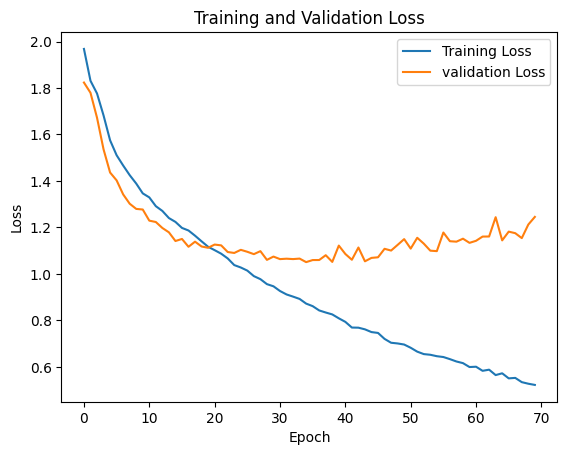

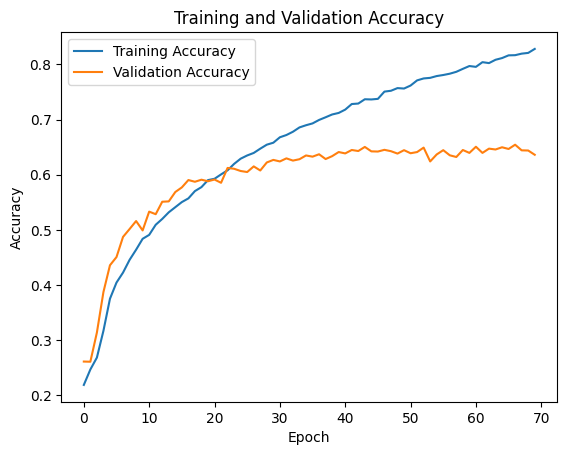

In [15]:
plot_graph(model_results)